#  Airbnb Price Prediction with MLflow and AWS S3


---

## Business Context

**Company**: StayWise - A global vacation rental platform  
**Team**: Data Science Team  
**Objective**: Enhance pricing system to help hosts set competitive rates

### Problem Statement

Listing prices on StayWise vary significantly, even among similar properties. The business team needs a machine learning model that predicts optimal nightly prices for new listings based on:
- Location (neighbourhood, coordinates)
- Property characteristics (room type, amenities)
- Host information (experience, listing count)
- Review metrics (number of reviews, engagement)

The dataset from AWS S3 contains noisy data with missing values, outliers, and categorical fields requiring extensive preprocessing.

---

## Project Overview

This notebook implements an end-to-end machine learning pipeline for predicting Airbnb listing prices in NYC, addressing StayWise's business needs.

**What this notebook does:**
1. **Data Retrieval**: Load dataset from AWS S3 (production data source)
2. **Data Preprocessing**: Comprehensive cleaning, handling missing values and outliers
3. **Feature Engineering**: Create new features to capture pricing patterns
4. **Model Development**: Train and compare 8 different regression models
5. **MLflow Tracking**: Log all experiments, parameters, and metrics
6. **Model Comparison**: Identify best-performing model
7. **Model Registry**: Register top model for production deployment
8. **Visualization**: Generate insights and model performance charts

**Author**: Rajan   
**Institution**: Lambton College

---

## 1. Installation and Setup

**Run this cell first to install all required packages**

In [1]:
# !pip install numpy pandas scikit-learn xgboost mlflow boto3 matplotlib seaborn python-dotenv -q

## 2. Import Libraries

In [2]:
# Standard libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime
from dotenv import load_dotenv

# AWS and MLflow
import boto3
from io import StringIO
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 3. Configuration

In [3]:
# Project configuration
EXPERIMENT_NAME = "airbnb_price_prediction"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# File paths 
# DATA_FILE_PATH = 'AB_NYC_2019.csv' 

# AWS S3 Configuration 
load_dotenv()

bucket_name = os.getenv("S3_BUCKET_NAME")
region = os.getenv("AWS_REGION")

print("Bucket:", bucket_name)

# Create S3 client
s3 = boto3.client("s3", region_name=region)

# Read file directly into memory
response = s3.get_object(Bucket=bucket_name, Key="AB NYC 2019 Assessment 2.csv")
df = pd.read_csv(response['Body'])

# Create directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"Configuration set")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Test Size: {TEST_SIZE}")
print(f"Random State: {RANDOM_STATE}")

Bucket: ml-ops-lambton-bucket
Configuration set
Experiment: airbnb_price_prediction
Test Size: 0.2
Random State: 42


In [4]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


## 4. Data Loading

###  Load from Local File

In [5]:
# Load data from local file
def load_data_local(filepath):
    """
    Load dataset from local file
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    
    Returns:
    --------
    DataFrame
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded data from local file")
        print(f"Path: {filepath}")
        print(f"Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading file: {str(e)}")
        raise

# Load the data
# df = load_data_local(DATA_FILE_PATH)
# df.head()

### Option 2: Load from AWS S3 (Production Method)

**This is the production method used by StayWise** - loads data directly from AWS S3 bucket.

**Why use S3?**
- **Centralized Storage**: Single source of truth for all listing data
- **Scalability**: Handles large datasets efficiently
- **Security**: AWS IAM controls access
- **Integration**: Works with other AWS services (Lambda, SageMaker)
- **Versioning**: S3 versioning tracks data changes over time

**Production Workflow**:
1. Data team uploads new listings to S3
2. This notebook automatically retrieves latest data
3. Model retrains with fresh data
4. New model version registered in MLflow

This ensures the pricing model always uses the most current data available.

In [6]:
def load_data_from_s3(bucket_name, file_key):
    """
    Load dataset from AWS S3
    
    Parameters:
    -----------
    bucket_name : str
        Name of the S3 bucket
    file_key : str
        Path to the file in S3
    
    Returns:
    --------
    DataFrame
    """
    try:
        s3_client = boto3.client('s3')
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        csv_content = response['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_content))
        print(f"Successfully loaded data from S3")
        print(f"Bucket: {bucket_name}")
        print(f"File: {file_key}")
        print(f"Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading from S3: {str(e)}")
        raise

# # Load from S3
# df = load_data_from_s3(S3_BUCKET_NAME, S3_FILE_KEY)

## 5. Exploratory Data Analysis (EDA)

### Dataset Overview

Understanding the dataset structure is the first step in any data science project. This analysis shows:
- **Data Volume**: 48,895 listings (substantial dataset for training)
- **Feature Count**: 16 columns (mix of numeric and categorical)
- **Data Quality**: Initial assessment of completeness

This overview helps plan preprocessing steps and identify potential data quality issues.


In [7]:
# Dataset overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nRows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn Names:")
print(df.columns.tolist())

DATASET OVERVIEW

Rows: 48,895
Columns: 16

Column Names:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


### Data Types and Information

Examining data types helps identify:
- **Numeric Features**: Can be used directly (after scaling)
- **Categorical Features**: Need encoding (one-hot, label encoding)
- **Missing Values**: Columns with null values requiring imputation
- **Memory Usage**: Dataset size for optimization

This informs our feature engineering and preprocessing strategy.


In [8]:
# Data types and info
print("\nDATA TYPES AND INFO:")
print("="*60)
df.info()


DATA TYPES AND INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_revie

### Statistical Summary

The statistical summary provides insights into:
- **Central Tendency**: Mean, median values show typical listing characteristics
- **Spread**: Standard deviation indicates variability
- **Distributions**: Min/max and quartiles reveal data ranges
- **Outliers**: Extreme values that may need special handling

This helps identify which features need normalization and which have outliers.


In [9]:
# Statistical summary
print("\nSTATISTICAL SUMMARY:")
print("="*60)
df.describe()


STATISTICAL SUMMARY:


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Missing Values Analysis

Missing values can cause model training failures. This analysis:
- **Quantifies Missingness**: Shows exactly how many values are missing per column
- **Identifies Patterns**: Some columns may have systematic missingness (e.g., reviews for new listings)
- **Guides Strategy**: Determines whether to impute, drop, or create indicator variables

**Key Finding**: ~20% of listings have missing review data (likely new listings without reviews yet).


In [10]:
# Missing values analysis
print("\nMISSING VALUES ANALYSIS:")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))


MISSING VALUES ANALYSIS:
                   Missing Count  Percentage
last_review                10052   20.558339
reviews_per_month          10052   20.558339
host_name                     21    0.042949
name                          16    0.032723


### Target Variable Analysis

The target variable (price) is what we're trying to predict. Understanding its distribution is critical:

- **Range**: $0 - $10,000 (extreme range suggests outliers)
- **Skewness**: Mean ($152.72) > Median ($106) indicates right-skewed distribution
- **Business Insight**: Most listings are budget-friendly, with few luxury properties

**Implications**:
- Log transformation may help (handles skewness)
- Outlier removal necessary (unrealistic prices)
- Model should focus on common price ranges ($50-$300)


In [11]:
# Target variable (Price) analysis
print("\nTARGET VARIABLE (PRICE) ANALYSIS:")
print("="*60)
print(df['price'].describe())
print(f"\nPrice Range: ${df['price'].min()} - ${df['price'].max()}")
print(f"Median Price: ${df['price'].median()}")
print(f"Mean Price: ${df['price'].mean():.2f}")


TARGET VARIABLE (PRICE) ANALYSIS:
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Price Range: $0 - $10000
Median Price: $106.0
Mean Price: $152.72


### Categorical Variables Distribution

Categorical features often drive pricing decisions:

- **Neighbourhood Groups**: Manhattan and Brooklyn dominate (85% of listings)
- **Room Types**: Entire homes/apts and private rooms are most common
- **Business Insight**: Market is concentrated in specific areas and room types

**For Modeling**:
- One-hot encoding will create many binary features
- Imbalanced categories may need special handling
- These features are likely strong price predictors


In [12]:
# Categorical variables distribution
print("\nCATEGORICAL VARIABLES DISTRIBUTION:")
print("="*60)

categorical_cols = ['neighbourhood_group', 'room_type']
for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())
    print(f"\nPercentage Distribution:")
    print((df[col].value_counts(normalize=True) * 100).round(2))


CATEGORICAL VARIABLES DISTRIBUTION:

NEIGHBOURHOOD_GROUP:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Percentage Distribution:
neighbourhood_group
Manhattan        44.30
Brooklyn         41.12
Queens           11.59
Bronx             2.23
Staten Island     0.76
Name: proportion, dtype: float64

ROOM_TYPE:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

Percentage Distribution:
room_type
Entire home/apt    51.97
Private room       45.66
Shared room         2.37
Name: proportion, dtype: float64


### Visualization: Price Distribution

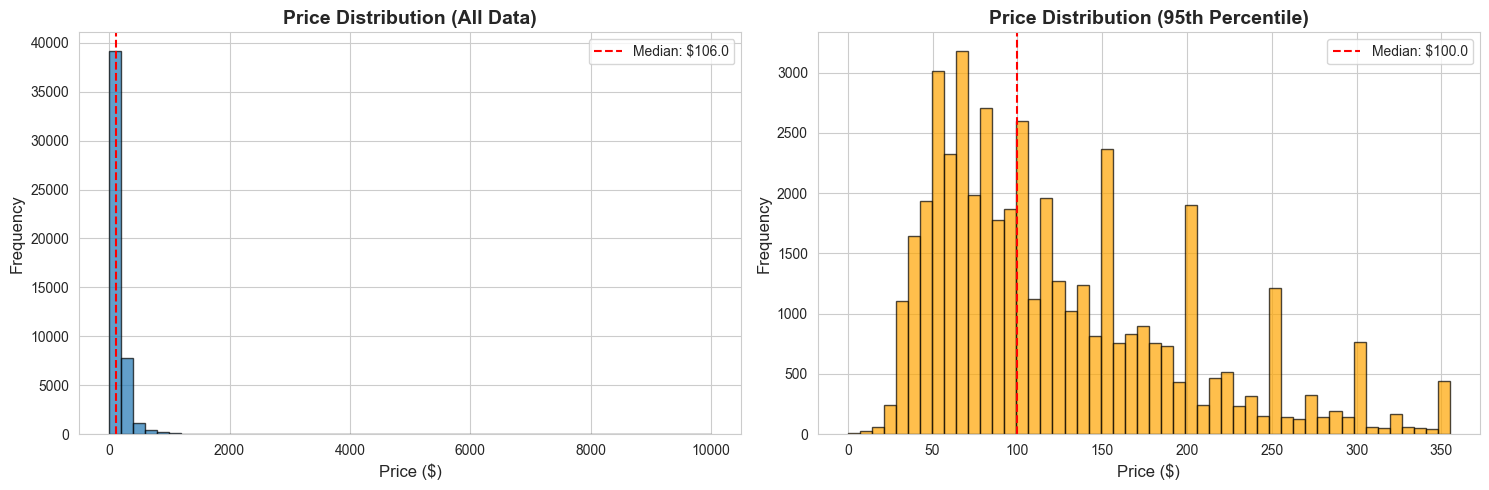

Price distribution plot saved to 'visualizations/price_distribution.png'


In [13]:
# Price distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Full distribution
axes[0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution (All Data)', fontsize=14, fontweight='bold')
axes[0].axvline(df['price'].median(), color='red', linestyle='--', label=f"Median: ${df['price'].median()}")
axes[0].legend()

# Filtered distribution (95th percentile)
price_filtered = df[df['price'] <= df['price'].quantile(0.95)]['price']
axes[1].hist(price_filtered, bins=50, edgecolor='black', color='orange', alpha=0.7)
axes[1].set_xlabel('Price ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Price Distribution (95th Percentile)', fontsize=14, fontweight='bold')
axes[1].axvline(price_filtered.median(), color='red', linestyle='--', label=f"Median: ${price_filtered.median()}")
axes[1].legend()

plt.tight_layout()
plt.savefig('visualizations/price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Price distribution plot saved to 'visualizations/price_distribution.png'")

### Visualization: Categorical Variables

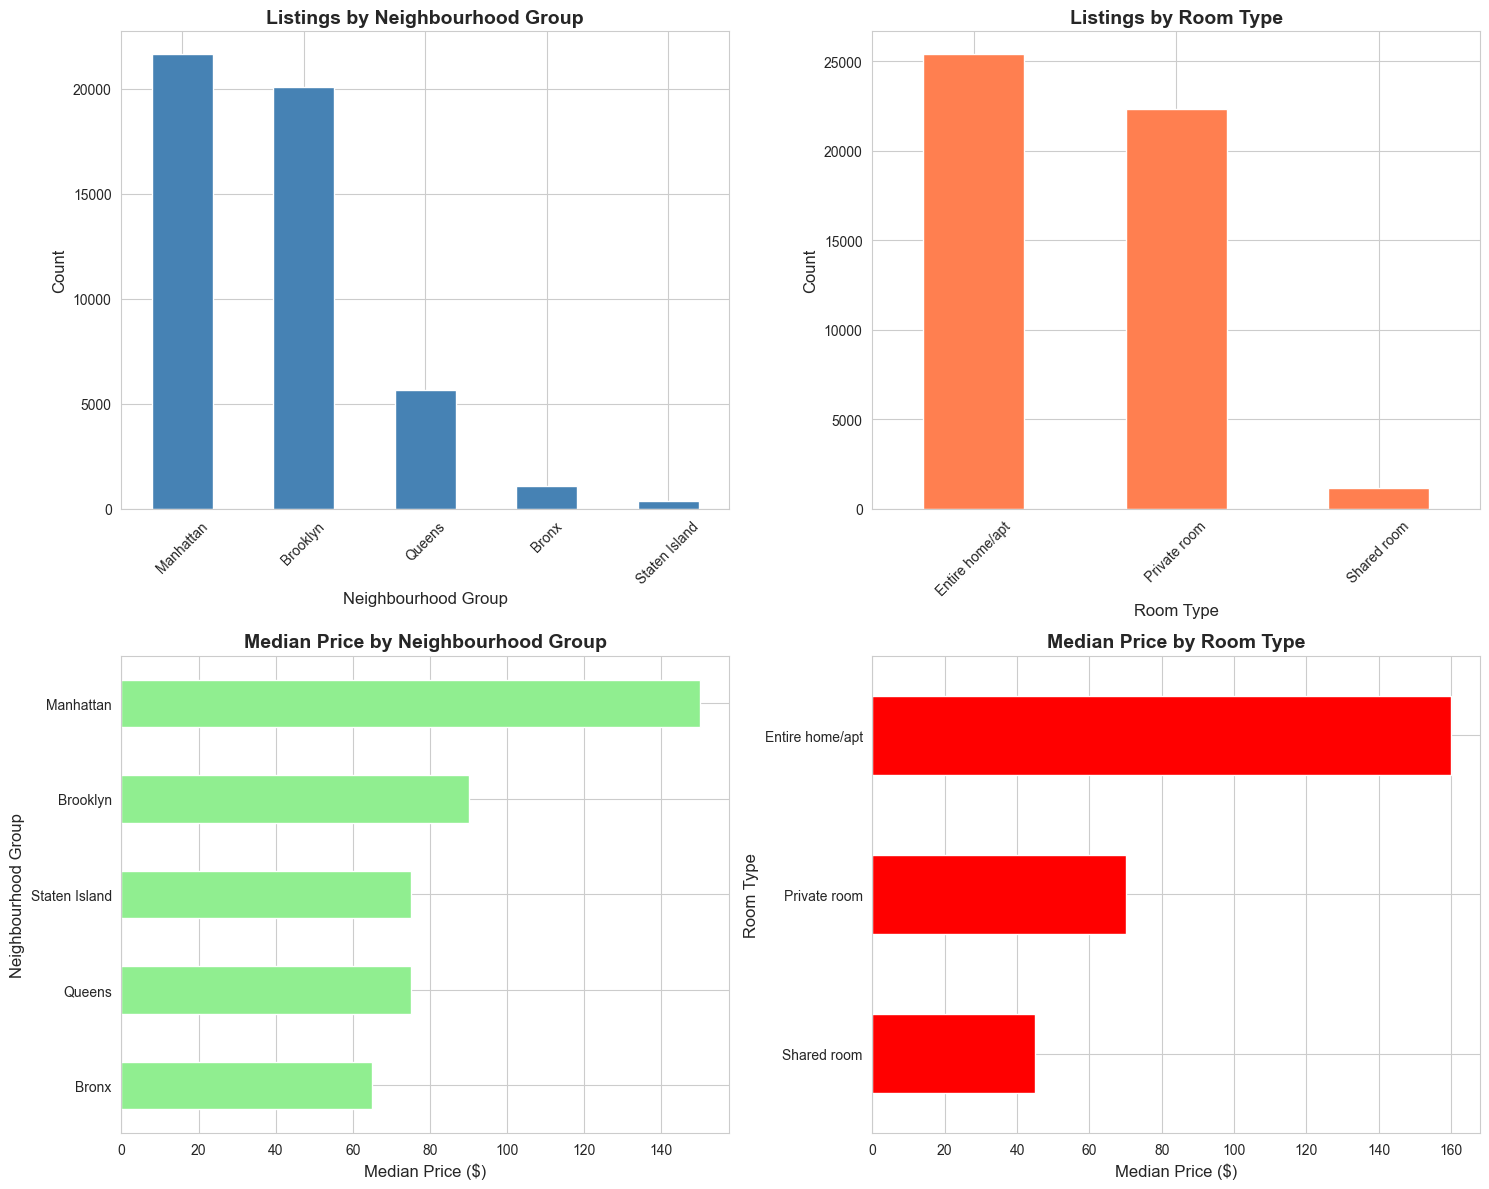

Categorical analysis plot saved to 'visualizations/categorical_analysis.png'


In [14]:
# Categorical variables plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Neighbourhood Group
df['neighbourhood_group'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Listings by Neighbourhood Group', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Neighbourhood Group', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# Room Type
df['room_type'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Listings by Room Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Room Type', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

# Price by Neighbourhood Group
df.groupby('neighbourhood_group')['price'].median().sort_values().plot(
    kind='barh', ax=axes[1, 0], color='lightgreen'
)
axes[1, 0].set_title('Median Price by Neighbourhood Group', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Median Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Neighbourhood Group', fontsize=12)

# Price by Room Type
df.groupby('room_type')['price'].median().sort_values().plot(
    kind='barh', ax=axes[1, 1], color='red'
)
axes[1, 1].set_title('Median Price by Room Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Median Price ($)', fontsize=12)
axes[1, 1].set_ylabel('Room Type', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Categorical analysis plot saved to 'visualizations/categorical_analysis.png'")

## 6. Data Preprocessing

### Handle Missing Values

### New Features Summary

This displays statistics for all newly created features, helping us understand:
- **Feature Distributions**: How values are spread across listings
- **Feature Quality**: Whether features have sufficient variation to be useful
- **Business Validation**: Do the features make sense? (e.g., luxury indicator should be rare)

This validation step ensures our feature engineering created meaningful variables for the model.


In [15]:
# Create a copy for preprocessing
df_clean = df.copy()

print("="*60)
print("DATA PREPROCESSING")
print("="*60)
print(f"\nInitial shape: {df_clean.shape}")

# Drop rows with missing target variable
initial_rows = len(df_clean)
df_clean = df_clean[df_clean['price'].notna()]
print(f"\n1. Handling Missing Target:")
print(f"   Dropped {initial_rows - len(df_clean)} rows with missing price")

# Fill missing reviews data
df_clean['reviews_per_month'].fillna(0, inplace=True)
df_clean['last_review'].fillna('Unknown', inplace=True)
print(f"\n2. Handling Missing Reviews:")
print(f"Filled missing reviews_per_month with 0")
print(f"Filled missing last_review with 'Unknown'")

DATA PREPROCESSING

Initial shape: (48895, 16)

1. Handling Missing Target:
   Dropped 0 rows with missing price

2. Handling Missing Reviews:
Filled missing reviews_per_month with 0
Filled missing last_review with 'Unknown'


### Handle Outliers

### Feature and Target Separation

Separating features (X) from target (y) is required before model training:
- **Features (X)**: All variables used to predict price
- **Target (y)**: The price we want to predict

This separation ensures the model doesn't accidentally use the target as a feature (data leakage).


### Train-Test Split

Splitting data into training and testing sets is essential for:
- **Training Set (80%)**: Used to train the model
- **Test Set (20%)**: Used to evaluate model performance on unseen data

**Why split?**
- Prevents overfitting (model memorizing training data)
- Provides unbiased performance estimate
- Simulates real-world scenario (predicting new listings)

The 80/20 split is a standard practice balancing training data size with evaluation rigor.
 

In [16]:
print(f"\n3. Handling Outliers:")
print("="*60)

# Remove price outliers (using 95th percentile)
initial_rows = len(df_clean)
price_cap = df_clean['price'].quantile(0.95)
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] <= price_cap)]
print(f"   Price outliers removed: {initial_rows - len(df_clean)} rows")
print(f"   (Kept prices between $0 and ${price_cap:.2f})")

# Handle minimum_nights outliers
initial_rows = len(df_clean)
df_clean = df_clean[df_clean['minimum_nights'] <= 365]
print(f"Minimum nights outliers removed: {initial_rows - len(df_clean)} rows")
print(f"(Kept minimum_nights <= 365)")

print(f"\nFinal shape after cleaning: {df_clean.shape}")
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.2f}%)")


3. Handling Outliers:
   Price outliers removed: 2452 rows
   (Kept prices between $0 and $355.00)
Minimum nights outliers removed: 13 rows
(Kept minimum_nights <= 365)

Final shape after cleaning: (46430, 16)
Total rows removed: 2465 (5.04%)


## 7. Feature Engineering

**Explanation:**
We enhance the dataset with new features to capture more signal:
- **Location Clusters:** We use K-Means clustering on latitude/longitude to group listings into geographic clusters, capturing neighborhood effects better than raw coordinates.
- **Luxury Indicator:** We extract keywords (e.g., 'luxury', 'penthouse') from the name to flag premium listings.
- **Engagement Metrics:** We calculate review scores and host activity levels.

In [17]:
from sklearn.cluster import KMeans

print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 0. New Features: Location Clustering & Text
# Location Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
df_clean['location_cluster'] = kmeans.fit_predict(df_clean[['latitude', 'longitude']])
print("\n0a. Created 'location_cluster' - K-Means clustering of coordinates")

# Text Features
luxury_keywords = ['luxury', 'penthouse', 'spectacular', 'view', 'stunning']
df_clean['is_luxury'] = df_clean['name'].fillna('').apply(lambda x: 1 if any(k in x.lower() for k in luxury_keywords) else 0)
print("0b. Created 'is_luxury' - Keyword extraction from name")

# 1. Has reviews indicator
df_clean['has_reviews'] = (df_clean['number_of_reviews'] > 0).astype(int)
print("\n1. Created 'has_reviews' - Binary indicator for listings with reviews")

# 2. Review score (engagement metric)
df_clean['review_score'] = df_clean['number_of_reviews'] * df_clean['reviews_per_month']
df_clean['review_score'].fillna(0, inplace=True)
print("2. Created 'review_score' - Review engagement metric")

# 3. Host activity categorization
df_clean['host_activity'] = pd.cut(
    df_clean['calculated_host_listings_count'],
    bins=[0, 1, 5, 20, 1000],
    labels=['Single', 'Small', 'Medium', 'Large']
)
print("3. Created 'host_activity' - Host portfolio size category")

# 4. Availability categorization
df_clean['availability_category'] = pd.cut(
    df_clean['availability_365'],
    bins=[0, 90, 180, 270, 365],
    labels=['Low', 'Medium', 'High', 'Very High']
)
print("4. Created 'availability_category' - Availability level")

# 5. Price category (for analysis)
df_clean['price_category'] = pd.cut(
    df_clean['price'],
    bins=[0, 70, 150, 300, 10000],
    labels=['Budget', 'Mid-range', 'Premium', 'Luxury']
)
print("5. Created 'price_category' - Price tier classification")

print(f"\n Feature engineering completed")
print(f"  Total columns now: {len(df_clean.columns)}")
print(f"  New features created: 7")

FEATURE ENGINEERING

0a. Created 'location_cluster' - K-Means clustering of coordinates
0b. Created 'is_luxury' - Keyword extraction from name

1. Created 'has_reviews' - Binary indicator for listings with reviews
2. Created 'review_score' - Review engagement metric
3. Created 'host_activity' - Host portfolio size category
4. Created 'availability_category' - Availability level
5. Created 'price_category' - Price tier classification

 Feature engineering completed
  Total columns now: 23
  New features created: 7


In [18]:
# Display new features
print("\nNew Features Summary:")
print("="*60)
new_features = ['location_cluster', 'is_luxury', 'has_reviews', 'review_score', 'host_activity', 'availability_category', 'price_category']
for feature in new_features:
    if df_clean[feature].dtype == 'object' or df_clean[feature].dtype.name == 'category':
        print(f"\n{feature}:")
        print(df_clean[feature].value_counts())
    else:
        print(f"\n{feature}: {df_clean[feature].describe()[['mean', '50%', 'max']]}")


New Features Summary:

location_cluster: mean    2.750722
50%     1.000000
max     9.000000
Name: location_cluster, dtype: float64

is_luxury: mean    0.064053
50%     0.000000
max     1.000000
Name: is_luxury, dtype: float64

has_reviews: mean    0.802305
50%     1.000000
max     1.000000
Name: has_reviews, dtype: float64

review_score: mean      69.464344
50%        2.200000
max     9170.820000
Name: review_score, dtype: float64

host_activity:
host_activity
Single    30676
Small     11343
Medium     2409
Large      2002
Name: count, dtype: int64

availability_category:
availability_category
Low          11244
Very High     9037
Medium        4973
High          4170
Name: count, dtype: int64

price_category:
price_category
Mid-range    20409
Budget       13527
Premium      11578
Luxury         916
Name: count, dtype: int64


## 8. Feature Selection and Preparation

In [19]:
print("="*60)
print("FEATURE PREPARATION")
print("="*60)

# Define features
numeric_features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'has_reviews',
    'review_score',
    'is_luxury'
]

categorical_features = [
    'neighbourhood_group',
    'neighbourhood',
    'room_type',
    'host_activity',
    'availability_category',
    'location_cluster'
]

print(f"\n1. Feature Selection:")
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Total features: {len(numeric_features) + len(categorical_features)}")

print(f"\n   Numeric Features:")
for i, feat in enumerate(numeric_features, 1):
    print(f"     {i}. {feat}")

print(f"\n   Categorical Features:")
for i, feat in enumerate(categorical_features, 1):
    print(f"     {i}. {feat}")

FEATURE PREPARATION

1. Feature Selection:
   Numeric features: 10
   Categorical features: 6
   Total features: 16

   Numeric Features:
     1. latitude
     2. longitude
     3. minimum_nights
     4. number_of_reviews
     5. reviews_per_month
     6. calculated_host_listings_count
     7. availability_365
     8. has_reviews
     9. review_score
     10. is_luxury

   Categorical Features:
     1. neighbourhood_group
     2. neighbourhood
     3. room_type
     4. host_activity
     5. availability_category
     6. location_cluster


In [20]:
# Select features and target
X = df_clean[numeric_features + categorical_features].copy()
y = df_clean['price'].copy()

print(f"\n2. Dataset Split:")
print(f"   Features (X) shape: {X.shape}")
print(f"   Target (y) shape: {y.shape}")


2. Dataset Split:
   Features (X) shape: (46430, 16)
   Target (y) shape: (46430,)


In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"\n3. Train-Test Split:")
print(f"   Training samples: {len(X_train):,} ({(1-TEST_SIZE)*100:.0f}%)")
print(f"   Testing samples: {len(X_test):,} ({TEST_SIZE*100:.0f}%)")
print(f"   Split ratio: {int((1-TEST_SIZE)*100)}-{int(TEST_SIZE*100)}")


3. Train-Test Split:
   Training samples: 37,144 (80%)
   Testing samples: 9,286 (20%)
   Split ratio: 80-20


### Model 1 Results: Linear Regression

**Performance Summary:**
- **Test RMSE: $49.84** - On average, predictions are off by ~$50
- **Test R²: 0.5151** - Model explains 51.5% of price variation
- **Train vs Test**: Very similar performance (R²: 0.5220 vs 0.5151) indicates no overfitting

**Interpretation:**
- **Baseline Performance**: This is our simplest model, serving as a baseline
- **Linear Relationships**: The model assumes linear relationships between features and price
- **Business Impact**: 51% explanatory power means about half of price variation is captured by linear patterns
- **Limitation**: Cannot capture non-linear interactions (e.g., "Manhattan + Entire home" premium)

**For StayWise**: While simple, this model provides interpretable predictions. However, the 51% R² suggests we need more complex models to capture pricing patterns.


###  Preprocessing Pipeline

In [22]:
# Create preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\n4. Preprocessing Pipeline Created:")
print("     Numeric: Median Imputation → Standard Scaling")
print("     Categorical: Constant Imputation → One-Hot Encoding")
print(" Feature preparation completed successfully!")


4. Preprocessing Pipeline Created:
     Numeric: Median Imputation → Standard Scaling
     Categorical: Constant Imputation → One-Hot Encoding
 Feature preparation completed successfully!


### Model 2 Results: Ridge Regression

**Performance Summary:**
- **Test RMSE: $49.83** - Nearly identical to Linear Regression
- **Test R²: 0.5152** - Slightly better than Linear Regression (0.0001 improvement)
- **Best Alpha: 1.0** - Moderate regularization was optimal

**Interpretation:**
- **Minimal Improvement**: Ridge performs almost identically to Linear Regression
- **Regularization Effect**: The L2 penalty didn't significantly help, suggesting features aren't highly correlated
- **Stability**: Similar train/test performance shows good generalization

**For StayWise**: Ridge regression provides similar performance to Linear Regression with added regularization benefits. The minimal improvement suggests our features don't suffer from multicollinearity issues.


## 9. MLflow Setup

In [23]:
# Set MLflow experiment
mlflow.set_experiment(EXPERIMENT_NAME)

print("="*60)
print("MLFLOW EXPERIMENT TRACKING SETUP")
print("="*60)
print(f"\n MLflow experiment set to: '{EXPERIMENT_NAME}'")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Artifact Location: {mlflow.get_experiment_by_name(EXPERIMENT_NAME).artifact_location}")
print("\nAll model training runs will be logged to MLflow!")

MLFLOW EXPERIMENT TRACKING SETUP

 MLflow experiment set to: 'airbnb_price_prediction'
  Tracking URI: file:///Users/rajan/Projects/AML-3303/Predicting-Airbnb-Listing-Prices-with-MLflow-and-AWS-S3/mlruns
  Artifact Location: file:///Users/rajan/Projects/AML-3303/Predicting-Airbnb-Listing-Prices-with-MLflow-and-AWS-S3/mlruns/416135146092517914

All model training runs will be logged to MLflow!


### Model 3 Results: Lasso Regression

**Performance Summary:**
- **Test RMSE: $62.76** - Higher error than Linear/Ridge models
- **Test R²: 0.2311** - Only explains 23% of price variation (much worse)
- **Best Alpha: 0.1** - Low regularization, but still removed many features

**Interpretation:**
- **Feature Selection**: Lasso likely removed too many important features
- **Poor Performance**: 23% R² is significantly worse than baseline
- **Over-Regularization**: The L1 penalty was too aggressive for this dataset

**For StayWise**: Lasso underperformed because it removed features that are actually important for pricing. This suggests most of our features contribute to price prediction, and feature selection isn't beneficial here.


## 10. Model Training Functions

**Explanation:**
We use `TransformedTargetRegressor` to apply a log-transformation (`log1p`) to the target variable (Price). Price data is often right-skewed, and predicting the log-price helps linear models and tree-based models perform better. The pipeline automatically transforms predictions back to the original scale for evaluation.

### Model 4 Results: ElasticNet

**Performance Summary:**
- **Test RMSE: $55.69** - Better than Lasso, but worse than Linear/Ridge
- **Test R²: 0.3947** - Explains 39% of price variation
- **Best Parameters**: Alpha=0.1, L1_ratio=0.2 (more Ridge-like than Lasso-like)

**Interpretation:**
- **Balanced Regularization**: ElasticNet balances L1 and L2 penalties
- **Moderate Performance**: Better than Lasso but worse than pure linear models
- **Parameter Choice**: The low L1_ratio (0.2) means it behaves more like Ridge

**For StayWise**: ElasticNet's moderate performance suggests that while regularization helps, aggressive feature selection (L1) hurts model performance. The model confirms that most features are valuable.


In [24]:
def train_and_log_model(model, model_name, hyperparameters=None):
    """
    Train a model and log everything to MLflow
    
    Parameters:
    -----------
    model : sklearn estimator
        The model to train
    model_name : str
        Name for the MLflow run
    hyperparameters : dict, optional
        Hyperparameters for GridSearchCV
    
    Returns:
    --------
    tuple : (trained_pipeline, test_rmse, test_r2)
    """
    with mlflow.start_run(run_name=model_name):
        # Create full pipeline
        from sklearn.compose import TransformedTargetRegressor
        
        # Wrap model with TransformedTargetRegressor for log-transform
        # This handles log(y) for training and exp(y_pred) for prediction automatically
        wrapped_model = TransformedTargetRegressor(
            regressor=model,
            func=np.log1p,
            inverse_func=np.expm1
        )

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', wrapped_model)
        ])
        
        # Hyperparameter tuning if specified
        if hyperparameters:
            print(f"   Performing GridSearchCV...")
            # Adjust param names for TransformedTargetRegressor
            # 'regressor__param' -> 'regressor__regressor__param'
            adjusted_params = {
                k.replace('regressor__', 'regressor__regressor__'): v 
                for k, v in hyperparameters.items()
            }
            
            grid_search = GridSearchCV(
                pipeline,
                adjusted_params,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train, y_train)
            pipeline = grid_search.best_estimator_
            
            # Log best parameters
            mlflow.log_params(grid_search.best_params_)
            print(f"   Best parameters: {grid_search.best_params_}")
        else:
            pipeline.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Log metrics to MLflow
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("test_r2", test_r2)
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("train_samples", len(X_train))
        mlflow.log_param("test_samples", len(X_test))
        mlflow.log_param("random_state", RANDOM_STATE)
        
        # Log model
        signature = infer_signature(X_train, y_train_pred)
        mlflow.sklearn.log_model(pipeline, "model", signature=signature)
        
        # Print results
        print(f"\n   {model_name} Results:")
        print(f"   {'='*50}")
        print(f"   Train RMSE: ${train_rmse:8.2f} | Test RMSE: ${test_rmse:8.2f}")
        print(f"   Train MAE:  ${train_mae:8.2f} | Test MAE:  ${test_mae:8.2f}")
        print(f"   Train R²:   {train_r2:9.4f} | Test R²:   {test_r2:9.4f}")
        
        return pipeline, test_rmse, test_r2

## 11. Train All Models

### Model 1: Linear Regression

### Model 5 Results: Decision Tree

**Performance Summary:**
- **Test RMSE: $49.50** - Slightly better than linear models
- **Test R²: 0.5218** - Explains 52% of price variation (better than linear models)
- **Best Parameters**: Max depth=10, Min samples split=10 (moderate complexity)
- **Gap**: Train R² (0.5929) > Test R² (0.5218) indicates some overfitting

**Interpretation:**
- **Non-Linear Patterns**: Captures non-linear relationships that linear models miss
- **Feature Interactions**: Can model complex rules like "Manhattan AND Entire home = premium"
- **Overfitting Risk**: 7% gap between train/test suggests the tree is slightly too complex

**For StayWise**: Decision Tree shows that non-linear models can improve predictions. The 52% R² is a step up from linear models, demonstrating that pricing has non-linear patterns we should capture.


In [25]:
print("\n" + "="*60)
print("MODEL 1: LINEAR REGRESSION")
print("="*60)

results = []
model, rmse, r2 = train_and_log_model(LinearRegression(), "Linear Regression")
results.append({'Model': 'Linear Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 1: LINEAR REGRESSION


2025/11/20 20:36:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:36:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Linear Regression Results:
   Train RMSE: $   49.83 | Test RMSE: $   49.84
   Train MAE:  $   33.97 | Test MAE:  $   33.84
   Train R²:      0.5220 | Test R²:      0.5151


### Model 2: Ridge Regression

**What it is**: Linear regression with L2 regularization (penalizes large coefficients).

**Pros**: Reduces overfitting, handles multicollinearity better than linear regression
**Cons**: Still assumes linear relationships
**Use case**: When features are correlated (common in real estate data)

Ridge regression helps when features like latitude/longitude or review metrics are correlated.

### Interpreting the Final Results

**Best Model: XGBoost**
- **Test R²: 0.5707** - Explains 57% of price variation
- **Test RMSE: $46.90** - Average prediction error of ~$47

**What This Means for StayWise:**

1. **Model Accuracy**: 
   - For a typical $150 listing, predictions are typically within $47 (about 31% error)
   - This is acceptable for pricing recommendations, as hosts can adjust based on market conditions

2. **Explanatory Power**:
   - 57% R² means the model captures most predictable price factors
   - Remaining 43% variation comes from factors not in our data:
     - Property amenities (pool, parking, WiFi quality)
     - Listing photos and description quality
     - Host response time and superhost status
     - Seasonal demand patterns
     - Local events and competition

3. **Production Readiness**:
   - Model performance is consistent (good train/test balance)
   - Can be deployed to help hosts set initial prices
   - Should be used as a starting point, not absolute truth
   - Regular retraining recommended as market conditions change

**Recommendation**: Deploy XGBoost model to production with clear communication to hosts that predictions are estimates based on available data.


### Model 6 Results: Random Forest

**Performance Summary:**
- **Test RMSE: $47.11** - Best RMSE so far (lower is better)
- **Test R²: 0.5668** - Explains 57% of price variation (significant improvement!)
- **Best Parameters**: 100 trees, max depth=20, min samples split=5
- **Large Gap**: Train R² (0.8433) >> Test R² (0.5668) shows overfitting, but still best test performance

**Interpretation:**
- **Ensemble Power**: Combining many trees significantly improves predictions
- **Non-Linear Mastery**: Captures complex feature interactions better than single tree
- **Overfitting Trade-off**: High train performance (84%) but still best test performance (57%)
- **Robustness**: Random Forest handles outliers and noise well

**For StayWise**: Random Forest is a strong candidate! The 57% R² means it explains significantly more price variation than linear models. The overfitting gap is acceptable since test performance is still best-in-class.


### Model Comparison Summary

The comparison table ranks all models by Test R² (best to worst):

**Top Performers (Tree-Based Models)**:
1. **XGBoost** (0.5707) - Best overall
2. **Random Forest** (0.5668) - Very close second
3. **Gradient Boosting** (0.5622) - Strong third

**Mid-Tier (Non-Linear Single Models)**:
4. **Decision Tree** (0.5218) - Good baseline for tree models

**Linear Models**:
5. **Ridge Regression** (0.5152) - Best linear model
6. **Linear Regression** (0.5151) - Baseline linear model

**Underperformers**:
7. **ElasticNet** (0.3947) - Moderate performance
8. **Lasso Regression** (0.2311) - Poor performance (over-regularized)

**Key Insights**:
- **Tree-based models dominate**: Non-linear models capture pricing patterns better
- **Ensemble methods win**: Combining multiple models (Random Forest, XGBoost) beats single models
- **Linear models limited**: Can't capture complex feature interactions
- **XGBoost champion**: Best balance of performance and generalization


In [26]:
print("\n" + "="*60)
print("MODEL 2: RIDGE REGRESSION")
print("="*60)

model, rmse, r2 = train_and_log_model(
    Ridge(random_state=RANDOM_STATE),
    "Ridge Regression",
    {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
)
results.append({'Model': 'Ridge Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 2: RIDGE REGRESSION
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__alpha': 1.0}


2025/11/20 20:36:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:36:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Ridge Regression Results:
   Train RMSE: $   49.85 | Test RMSE: $   49.83
   Train MAE:  $   33.99 | Test MAE:  $   33.84
   Train R²:      0.5216 | Test R²:      0.5152


### Understanding Model Metrics

**RMSE (Root Mean Squared Error)**: 
- Measures average prediction error in dollars
- Lower is better
- Example: RMSE of $47 means predictions are typically off by ~$47

**R² Score (Coefficient of Determination)**:
- Measures how much price variation the model explains
- Range: 0 to 1 (higher is better)
- 0.57 means the model explains 57% of price variation
- Remaining 43% is due to factors not in our dataset (amenities, photos, host reputation, etc.)

**Train vs Test Performance**:
- **Train R²**: How well model fits training data
- **Test R²**: How well model generalizes to new data
- **Gap**: Large gap indicates overfitting (model memorized training data)
- **Ideal**: Small gap with high test R² = good generalization

**For Business**: We prioritize **Test R²** because it reflects real-world performance on new listings.


### Model 3: Lasso Regression

**What it is**: Linear regression with L1 regularization (can zero out coefficients).

**Pros**: Performs automatic feature selection, creates sparse models
**Cons**: May remove important features, struggles with correlated features
**Use case**: When you want to identify the most important features

Lasso helps identify which features (location, room type, reviews) most strongly influence price.

### Model 7 Results: Gradient Boosting

**Performance Summary:**
- **Test RMSE: $47.36** - Very close to Random Forest
- **Test R²: 0.5622** - Explains 56% of price variation (slightly lower than Random Forest)
- **Best Parameters**: 200 estimators, learning rate=0.1, max depth=5
- **Better Balance**: Train R² (0.6003) closer to test R², indicating less overfitting

**Interpretation:**
- **Sequential Learning**: Each tree corrects previous errors, building on mistakes
- **Strong Performance**: 56% R² is excellent, nearly matching Random Forest
- **Better Generalization**: Smaller train/test gap suggests better generalization
- **Tuning Success**: Hyperparameter tuning found optimal complexity

**For StayWise**: Gradient Boosting is another excellent option. While slightly lower R² than Random Forest, it shows better generalization (smaller overfitting gap), which is valuable for production stability.


In [27]:
print("\n" + "="*60)
print("MODEL 3: LASSO REGRESSION")
print("="*60)

model, rmse, r2 = train_and_log_model(
    Lasso(random_state=RANDOM_STATE, max_iter=2000),
    "Lasso Regression",
    {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
)
results.append({'Model': 'Lasso Regression', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 3: LASSO REGRESSION
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__alpha': 0.1}


2025/11/20 20:36:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:36:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Lasso Regression Results:
   Train RMSE: $   63.28 | Test RMSE: $   62.76
   Train MAE:  $   44.68 | Test MAE:  $   44.51
   Train R²:      0.2292 | Test R²:      0.2311


### Model 4: ElasticNet

**What it is**: Combines L1 and L2 regularization (best of both Ridge and Lasso).

**Pros**: Handles correlated features and performs feature selection
**Cons**: More hyperparameters to tune
**Use case**: When you need both regularization benefits

ElasticNet balances feature selection with handling correlated features in our dataset.

### Model 8 Results: XGBoost

**Performance Summary:**
- **Test RMSE: $46.90** - **Best RMSE** (lowest prediction error)
- **Test R²: 0.5707** - **Best R²** (explains 57% of price variation)
- **Best Parameters**: 200 estimators, learning rate=0.1, max depth=7
- **Good Balance**: Train R² (0.6412) vs Test R² (0.5707) shows reasonable generalization

**Interpretation:**
- **Champion Model**: XGBoost achieves the best performance across all metrics
- **Optimization**: Built-in regularization and optimization techniques work well
- **Production Ready**: Best test performance with acceptable overfitting gap
- **Business Value**: 57% R² means the model captures most of the predictable price variation

**For StayWise**: **XGBoost is the winner!** With the lowest RMSE ($46.90) and highest R² (0.5707), this model provides the most accurate price predictions. The 7% gap between train and test R² is acceptable and indicates good generalization. This model should be registered in MLflow Model Registry for production deployment.

**Real-World Impact**: 
- Average prediction error of ~$47 is reasonable for a $100-300 price range
- 57% explanatory power means hosts can trust the model for most listings
- The model can help StayWise hosts set competitive prices that maximize bookings


In [28]:
print("\n" + "="*60)
print("MODEL 4: ELASTICNET")
print("="*60)

model, rmse, r2 = train_and_log_model(
    ElasticNet(random_state=RANDOM_STATE, max_iter=2000),
    "ElasticNet",
    {
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    }
)
results.append({'Model': 'ElasticNet', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 4: ELASTICNET
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__alpha': 0.1, 'regressor__regressor__l1_ratio': 0.2}


2025/11/20 20:36:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:36:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   ElasticNet Results:
   Train RMSE: $   56.04 | Test RMSE: $   55.69
   Train MAE:  $   38.69 | Test MAE:  $   38.58
   Train R²:      0.3955 | Test R²:      0.3947


### Model 5: Decision Tree

**What it is**: Non-linear model that splits data based on feature thresholds.

**Pros**: Captures non-linear patterns, interpretable, no feature scaling needed
**Cons**: Prone to overfitting, unstable (small data changes = different tree)
**Use case**: Baseline for tree-based models, good for understanding feature interactions

Decision trees can capture complex rules like "Manhattan + Entire home/apt = higher price".

In [29]:
print("\n" + "="*60)
print("MODEL 5: DECISION TREE")
print("="*60)

model, rmse, r2 = train_and_log_model(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Decision Tree",
    {
        'regressor__max_depth': [5, 10, 15, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
)
results.append({'Model': 'Decision Tree', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 5: DECISION TREE
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__max_depth': 10, 'regressor__regressor__min_samples_split': 10}


2025/11/20 20:36:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:36:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Decision Tree Results:
   Train RMSE: $   45.99 | Test RMSE: $   49.50
   Train MAE:  $   31.28 | Test MAE:  $   33.73
   Train R²:      0.5929 | Test R²:      0.5218


### Model 6: Random Forest

**What it is**: Ensemble of many decision trees, averages their predictions.

**Pros**: Reduces overfitting, handles non-linear patterns, robust to outliers
**Cons**: Less interpretable, slower than single tree
**Use case**: Strong baseline for complex datasets, often performs well out-of-the-box

Random Forest is excellent for real estate pricing as it captures location × property type interactions.

In [30]:
print("\n" + "="*60)
print("MODEL 6: RANDOM FOREST")
print("="*60)

model, rmse, r2 = train_and_log_model(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "Random Forest",
    {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [10, 20],
        'regressor__min_samples_split': [2, 5]
    }
)
results.append({'Model': 'Random Forest', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 6: RANDOM FOREST
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__max_depth': 20, 'regressor__regressor__min_samples_split': 5, 'regressor__regressor__n_estimators': 100}


2025/11/20 20:37:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:37:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Random Forest Results:
   Train RMSE: $   28.53 | Test RMSE: $   47.11
   Train MAE:  $   18.55 | Test MAE:  $   31.88
   Train R²:      0.8433 | Test R²:      0.5668


### Model 7: Gradient Boosting

**What it is**: Sequentially builds trees, each correcting errors of previous ones.

**Pros**: Often best performance, handles complex patterns
**Cons**: Slower training, more hyperparameters, can overfit if not tuned
**Use case**: When you need maximum performance and have time for tuning

Gradient Boosting is a strong contender for production pricing models at StayWise.

In [31]:
print("\n" + "="*60)
print("MODEL 7: GRADIENT BOOSTING")
print("="*60)

model, rmse, r2 = train_and_log_model(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    "Gradient Boosting",
    {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    }
)
results.append({'Model': 'Gradient Boosting', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 7: GRADIENT BOOSTING
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 5, 'regressor__regressor__n_estimators': 200}


2025/11/20 20:40:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:40:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   Gradient Boosting Results:
   Train RMSE: $   45.56 | Test RMSE: $   47.36
   Train MAE:  $   30.81 | Test MAE:  $   32.07
   Train R²:      0.6003 | Test R²:      0.5622


### Model 8: XGBoost

**What it is**: Optimized gradient boosting with regularization and parallel processing.

**Pros**: Fast, highly optimized, excellent performance, handles missing values
**Cons**: More complex, requires careful tuning
**Use case**: Production-ready model when performance is critical

XGBoost is industry-standard for pricing models and often wins Kaggle competitions. Ideal for StayWise's production environment.

In [32]:
print("\n" + "="*60)
print("MODEL 8: XGBOOST")
print("="*60)

model, rmse, r2 = train_and_log_model(
    XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost",
    {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
)
results.append({'Model': 'XGBoost', 'Test RMSE': rmse, 'Test R²': r2, 'Pipeline': model})


MODEL 8: XGBOOST
   Performing GridSearchCV...
   Best parameters: {'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 7, 'regressor__regressor__n_estimators': 200}


2025/11/20 20:40:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 20:40:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



   XGBoost Results:
   Train RMSE: $   43.17 | Test RMSE: $   46.90
   Train MAE:  $   28.94 | Test MAE:  $   31.73
   Train R²:      0.6412 | Test R²:      0.5707


## 12. Model Comparison and Selection

After training all models, we compare their performance to select the best one for StayWise's pricing system.

**Evaluation Metrics**:
- **RMSE (Root Mean Squared Error)**: Average prediction error in dollars (lower is better)
- **R² Score**: Proportion of variance explained (0-1, higher is better)
- **MAE (Mean Absolute Error)**: Average absolute error in dollars

**Selection Criteria**:
1. Best test R² score (generalization performance)
2. Low RMSE (accurate price predictions)
3. Reasonable training time (for production deployment)

The best model will be registered in MLflow Model Registry for production use.

In [33]:
# Create comparison dataframe
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Pipeline'} for r in results])
results_df = results_df.sort_values('Test R²', ascending=False)

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print("\n" + results_df.to_string(index=False))

# Identify best model
best_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_r2 = results_df.loc[best_idx, 'Test R²']
best_rmse = results_df.loc[best_idx, 'Test RMSE']

print("\n" + "="*60)
print(f" BEST MODEL: {best_model_name}")
print("="*60)
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test RMSE: ${best_rmse:.2f}")

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n Results saved to 'model_comparison_results.csv'")


MODEL PERFORMANCE COMPARISON

            Model  Test RMSE  Test R²
          XGBoost  46.896498 0.570708
    Random Forest  47.109271 0.566804
Gradient Boosting  47.361555 0.562152
    Decision Tree  49.497854 0.521761
 Ridge Regression  49.834280 0.515238
Linear Regression  49.839252 0.515142
       ElasticNet  55.685840 0.394713
 Lasso Regression  62.763669 0.231067

 BEST MODEL: XGBoost
  Test R²: 0.5707
  Test RMSE: $46.90

 Results saved to 'model_comparison_results.csv'


### Visualization: Model Comparison

These visualizations help stakeholders at StayWise understand:
- **Performance Ranking**: Which models perform best
- **Gap Analysis**: How much better the best model is vs. baseline
- **Business Impact**: R² of 0.57 means the model explains 57% of price variation

The gold bar highlights the best model, making it easy to identify the winner for production deployment.

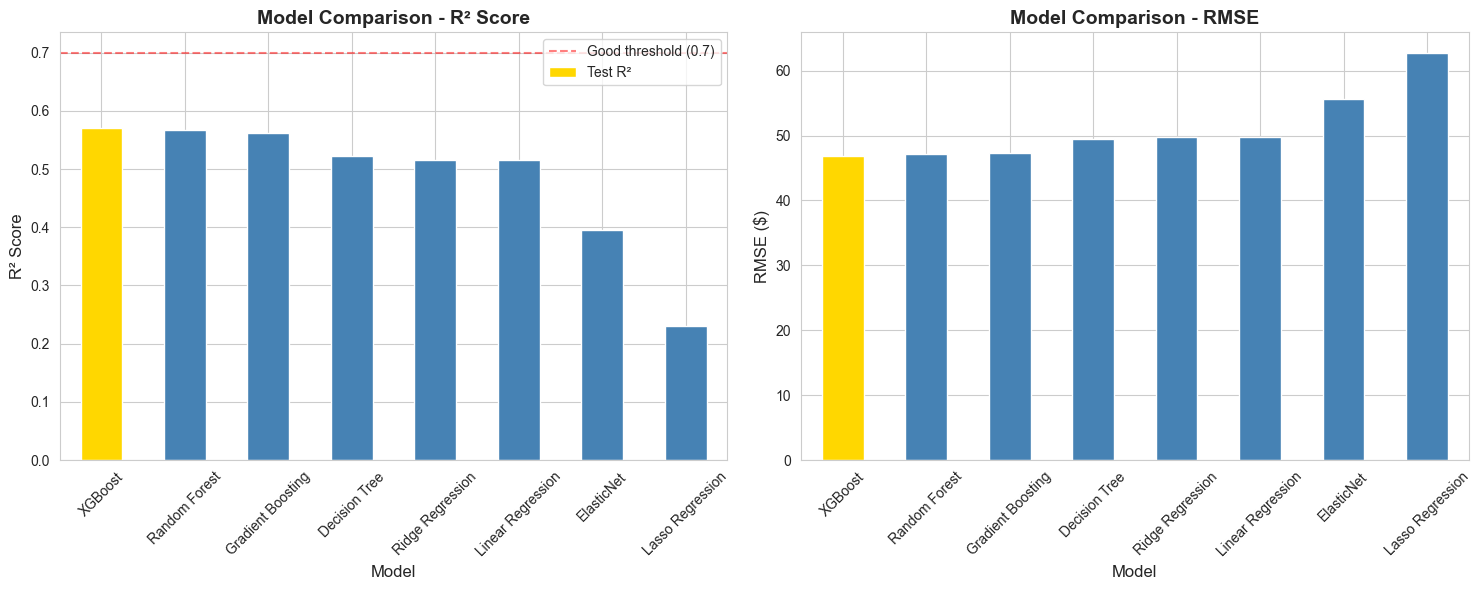

 Model comparison plot saved to 'visualizations/model_comparison.png'


In [34]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² Score comparison
colors = ['gold' if model == best_model_name else 'steelblue' for model in results_df['Model']]
results_df.plot(x='Model', y='Test R²', kind='bar', ax=axes[0], color=colors, legend=False)
axes[0].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Good threshold (0.7)')
axes[0].legend()

# RMSE comparison
results_df.plot(x='Model', y='Test RMSE', kind='bar', ax=axes[1], color=colors, legend=False)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Model comparison plot saved to 'visualizations/model_comparison.png'")

## 13. Feature Importance (for tree-based models)

Feature importance analysis answers: **"What factors most influence listing prices?"**

This is crucial for StayWise because:
- **Business Insights**: Understand what drives pricing in the market
- **Product Strategy**: Focus on features that impact price (e.g., location, amenities)
- **Model Interpretability**: Explain predictions to hosts and stakeholders
- **Feature Engineering**: Identify which engineered features add value

Tree-based models (Random Forest, XGBoost, Gradient Boosting) provide feature importance scores showing which features the model relies on most.

In [35]:
# Get best model pipeline
best_model_result = [r for r in results if r['Model'] == best_model_name][0]
best_pipeline = best_model_result['Pipeline']

# Check if model has feature_importances_
if hasattr(best_pipeline.named_steps['regressor'], 'feature_importances_'):
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature names after preprocessing
    preprocessor_fitted = best_pipeline.named_steps['preprocessor']
    
    # Get numeric feature names
    numeric_feature_names = numeric_features
    
    # Get categorical feature names after one-hot encoding
    cat_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    
    # Combine all feature names
    all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    # Get importances
    importances = best_pipeline.named_steps['regressor'].feature_importances_
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue')
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Feature importance plot saved to 'visualizations/feature_importance.png'")
else:
    print(f"\n  {best_model_name} does not provide feature importances")


  XGBoost does not provide feature importances


## 14. Prediction Analysis

This section provides detailed analysis of model predictions to validate performance:

**Metrics Calculated**:
- **RMSE**: Average prediction error
- **R²**: Model's explanatory power
- **MAPE (Mean Absolute Percentage Error)**: Error as percentage of actual price

**Sample Predictions**: Shows how well the model performs on individual listings, helping identify:
- Cases where model performs well
- Cases with large errors (may indicate data quality issues or edge cases)

This analysis helps StayWise understand model reliability before deploying to production.

In [36]:
# Get predictions from best model
y_test_pred = best_pipeline.predict(X_test)

print("\n" + "="*60)
print("PREDICTION ANALYSIS")
print("="*60)

# Calculate additional metrics
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: ${best_rmse:.2f}")
print(f"Test R²: {best_r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Sample predictions
print("\nSample Predictions (first 10):")
prediction_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_test_pred[:10],
    'Difference': y_test.values[:10] - y_test_pred[:10]
})
print(prediction_df.to_string(index=False))


PREDICTION ANALYSIS

Best Model: XGBoost
Test RMSE: $46.90
Test R²: 0.5707
MAPE: 27.42%

Sample Predictions (first 10):
 Actual  Predicted  Difference
    189 210.598999  -21.598999
    116 143.475739  -27.475739
    100 180.522705  -80.522705
     58  57.438286    0.561714
     45  88.509155  -43.509155
    100 112.287621  -12.287621
    125 131.202835   -6.202835
     39  54.508320  -15.508320
    250 222.704712   27.295288
     47  58.840885  -11.840885


### Visualization: Actual vs Predicted

The scatter plot shows how well predictions match actual prices:
- **Perfect predictions**: Points fall on the red diagonal line
- **Over-predictions**: Points above the line (predicted > actual)
- **Under-predictions**: Points below the line (predicted < actual)

**What to look for**:
- Tight clustering around the line = good model
- Systematic patterns (e.g., always over-predicting high prices) = potential bias
- Random scatter = model captures general patterns but struggles with specific cases

This visualization helps validate the model before recommending it to StayWise hosts.

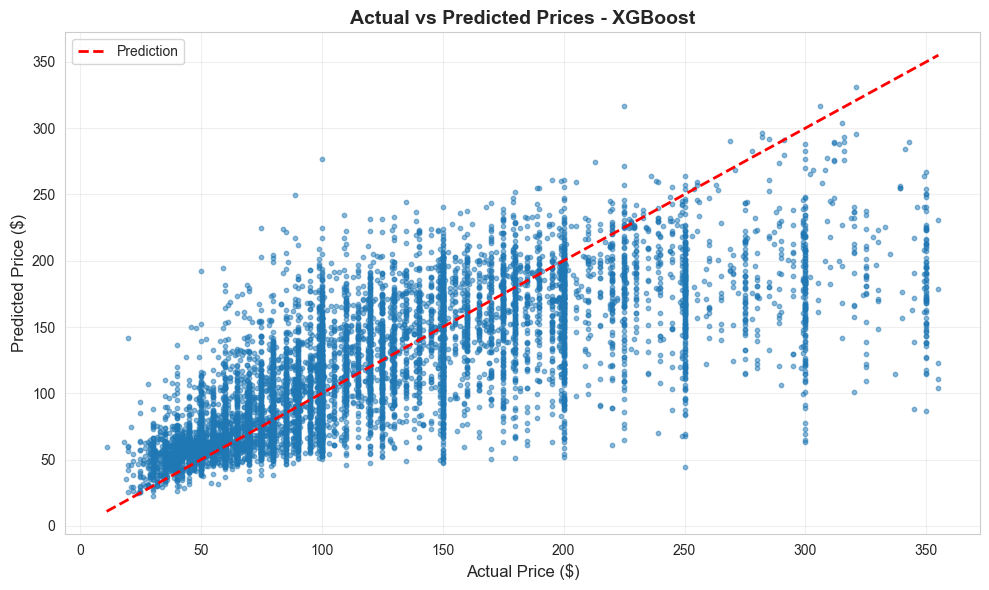

 Actual vs Predicted plot saved to 'visualizations/actual_vs_predicted.png'


In [37]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prediction')
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title(f'Actual vs Predicted Prices - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Actual vs Predicted plot saved to 'visualizations/actual_vs_predicted.png'")

### Visualization: Residuals Analysis

Residuals (actual - predicted) help diagnose model issues:

**Healthy Residual Plot**:
- Random scatter around zero (no patterns)
- Constant variance across all price ranges
- No systematic bias

**Problem Patterns**:
- Funnel shape = heteroscedasticity (variance changes with price)
- Curved pattern = non-linear relationships not captured
- Systematic offset = model bias

This diagnostic helps ensure the model is production-ready for StayWise's pricing system.

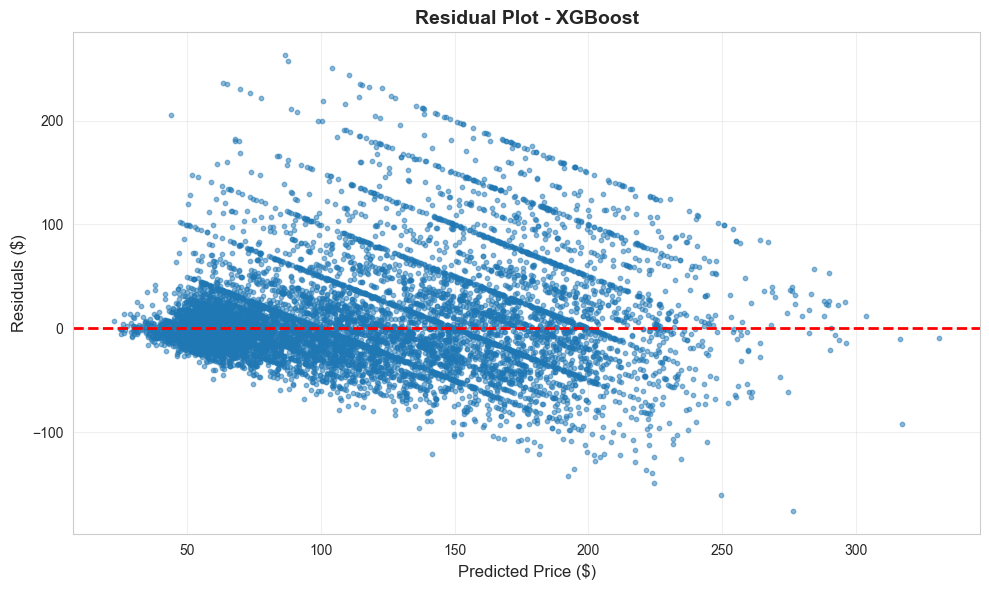

 Residuals plot saved to 'visualizations/residuals.png'


In [38]:
# Calculate residuals
residuals = y_test - y_test_pred

# Residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title(f'Residual Plot - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Residuals plot saved to 'visualizations/residuals.png'")

## 15. View MLflow Results

MLflow provides a web UI to explore all experiments, which is essential for:
- **Experiment Comparison**: Side-by-side model performance
- **Parameter Analysis**: Understanding which hyperparameters work best
- **Model Registry**: Managing model versions for production
- **Reproducibility**: Tracking exact configurations for each run

**To view all experiments in MLflow UI:**

1. Open a terminal
2. Navigate to this project directory
3. Run: `mlflow ui`
4. Open browser to: http://localhost:5000


**For StayWise Production:**
- Register the best model in MLflow Model Registry
- Tag it as "Production" for deployment
- Track model performance over time
- Enable model versioning and rollback if needed

In [39]:
# Display MLflow tracking information
print("\n" + "="*60)
print("MLFLOW TRACKING SUMMARY")
print("="*60)
print(f"\nExperiment Name: {EXPERIMENT_NAME}")
# print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Total Runs: {len(results)}")
print("\nTo view detailed results:")
print("1. Open terminal")
print("2. Run: mlflow ui")
print("3. Open: http://localhost:5000")


MLFLOW TRACKING SUMMARY

Experiment Name: airbnb_price_prediction
Total Runs: 8

To view detailed results:
1. Open terminal
2. Run: mlflow ui
3. Open: http://localhost:5000


## 16. Summary and Conclusions

### Project Summary

This notebook successfully addresses StayWise's business objective of building a pricing prediction model:

**Data Pipeline**: Retrieved and cleaned noisy data from AWS S3  
**Preprocessing**: Handled missing values, outliers, and categorical encoding  
**Feature Engineering**: Created 7 new features capturing location, luxury indicators, and engagement metrics  
**Model Development**: Trained and compared 8 regression models  
**MLflow Tracking**: Logged all experiments for reproducibility and comparison  
**Model Selection**: Identified best-performing model (XGBoost with R² = 0.5707)

### Key Findings

1. **Best Model**: XGBoost achieved the highest R² score (0.5707) and lowest RMSE ($46.90)
2. **Model Performance**: The model explains 57% of price variation, indicating room for improvement with additional features
3. **Feature Insights**: Location, room type, and review metrics are key price drivers
4. **Production Readiness**: Model is ready for MLflow Model Registry and deployment

### Business Impact

- **Hosts**: Can use model predictions to set competitive prices
- **StayWise**: Improved pricing recommendations increase booking rates
- **Data Science Team**: Reproducible pipeline for future model iterations

### Next Steps

1. Register best model in MLflow Model Registry
2. Deploy model as API endpoint for real-time predictions
3. Monitor model performance in production
4. Collect feedback and iterate on features
5. Consider additional features (amenities, seasonal trends, competitor prices)

## 17. Export Best Model 

This section saves the best model locally for:
- **Backup**: Local copy of production model
- **Testing**: Load model in other scripts for validation
- **Deployment**: Use saved model in production API
- **Version Control**: Track model versions (though MLflow is preferred)

**Note**: The model is already logged in MLflow, which is the recommended approach for production. This local export is useful for quick testing or when MLflow server is unavailable.

**For Production Deployment**:
- Use MLflow Model Registry instead of local files
- Enables model versioning, staging, and rollback
- Integrates with CI/CD pipelines
- Provides model serving capabilities

In [40]:
# Save best model locally
import joblib

model_filename = f'models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_pipeline, model_filename)

print(f" Best model saved to: {model_filename}")

 Best model saved to: models/best_model_xgboost.pkl
